In [7]:
import numpy as np
import pandas as pd
import pickle
import re
import sys

import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, HTML, Javascript, clear_output

sys.path.append("../data_prep/")
import preprocessing

import openai
import requests

sns.set_style('whitegrid')

In [8]:
run_first_time = False

openai.api_key = open("../data/openai_api.txt", "r").read().strip()

In [28]:
def chatgpt(essay):
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[{"role": "user", "content": f"Review the given essay on six analytic measures: Cohesion, Syntax, Vocabulary, Phraseology, Grammar, and Conventions. Review should follow below format\n\nmeaseure1: review1\n\nmeasure2: review2\n\n and so on\n\n{essay}",
                }]
    )
    response = response['choices'][0]['message']['content']
    return response.strip()

In [10]:
# define a function to assign score category based on scores
def assign_score_category(row):
    if (row[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']] <= 2.5).sum() > 4:
        return 'low'
    elif (row[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']] >= 4).sum() > 4:
        return 'high'
    else:
        return 'medium'

In [11]:
target_columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
feature_columns = ["num_mistakes", "sent_count", "sent_len", "word_count", "noun_count", "verb_count",
                   "adjective_count", "adverb_count"]

processed_df = pd.read_csv("../data/processed_essays.csv")
processed_df['score_category'] = processed_df.apply(assign_score_category, axis=1)

with open("../data/best_models.p", "rb") as f:
    models = pickle.load(f)

In [12]:
def run_all_cells_below(ev):
    global run_first_time
    display(
        Javascript(
            'IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'
        )
    )
    run_first_time = True

In [13]:
def token_to_vector(corpus, model):
    features = []

    for c in corpus:
        vectors = []
        for token in c:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)  # Take the mean since we need a 2D array instead of 3D
            features.append(avg_vec)
        else:
            features.append(np.zeros(model.vector_size))
    return np.array(features)

In [14]:
def df_to_html(df):
    df_html = df.to_html().replace("<th></th>", "").replace("<th>0</th>", "")
    df_html = df_html.replace('border="1"', 'style="border: 1px solid black;"')
    df_html = df_html.replace("<th>", '<th style="border: 1px solid black;">')
    df_html = df_html.replace("<td>", '<td style="border: 1px solid black;">')
    df_html = df_html.replace('" class="dataframe"', ' margin-left: auto; margin-right:auto"')
    return "<br>" + df_html + "<br>"

In [15]:
def highlight_mistakes(df):
    mistakes  = df.mistakes[0].split()
    corrections = df.corrected_words[0].split()
    essay = df.full_text[0]
    # essay = re.sub("\n+", "\n", essay)
    essay = essay.replace("\n", "<br>")

    for j, m in enumerate(mistakes):
        c = f"""
        <b>
            <span style='background-color: #FFCCCB'>{m}</span> 
            (<span style='background-color: lightgreen'>{corrections[j]}</span>)
        </b>
        """
        essay = " ".join([w if w != m else c for w in essay.split()])

    df.loc[0, "highlighted_essay"] = "<p style='background-color: #FFFFE0'>" + essay + "</p>"
    
    return df

In [16]:
# Textbox to enter essay
inp_box = widgets.Textarea(
    placeholder='Please enter your essay',
    layout=widgets.Layout(width='99%', height='200px'),
    rows=5,
    disabled=False
)

# Initialize the button to analyze the essay
analyze_btn_widget = widgets.Button(
    description='Analyze Essay',
    disabled=False,
    button_style='info',
    icon='submit'
)

# Initialize the button to get a sample essay
sample_btn_widget = widgets.Button(
    description='Sample Essay',
    disabled=False,
    button_style='info',
    icon='submit'
)

def get_sample_essay(ev):
    pdf = processed_df[(processed_df.num_mistakes > 10) & (processed_df.score_category == "low")].copy()
    pdf = pdf.reset_index(drop=True)
    inp_box.value = pdf.full_text[np.random.randint(0, len(pdf))]


h1 = widgets.HTML("<h2><center>Essay Evaluator for English Language Learners (ELLs)</center></h2>")
h2 = widgets.HTML("<i><center>Accurate feeback on essays for language development and expedite the grading cycle for teachers.</center></i>")

analyze_btn_widget.on_click(run_all_cells_below)
sample_btn_widget.on_click(get_sample_essay)

display(widgets.VBox([h1, h2, inp_box, widgets.HBox([analyze_btn_widget, sample_btn_widget])]))

<IPython.core.display.Javascript object>

In [20]:
essay = inp_box.value.strip()

if essay:
    display(
        HTML(f"""<h3 style='background-color: yellow; text-align: center'>
        Essay Scores
        </h3>""")
    )
    
    df = pd.DataFrame(columns=["full_text"])
    df.loc[0, "full_text"] = essay
    df = preprocessing.process_df(df)
    
    for t in target_columns:
        fmodel = models[t][0]
        scaler = models[t][1]
        model = models[t][2]
        
        if t == "phraseology":
            X = token_to_vector([df.lemmatized_text[0].split()], fmodel.wv)
            X = pd.DataFrame(data=X, columns=[f"f{i+1}" for i in range(X.shape[1])])
        elif t == "vocabulary":
            X = token_to_vector([df.lemmatized_text[0].split()], fmodel)
            X = pd.DataFrame(data=X, columns=[f"f{i+1}" for i in range(X.shape[1])])
        else:
            X = fmodel.transform(df.lemmatized_text)
            X = pd.DataFrame(X.toarray(), columns=fmodel.get_feature_names_out())
        
        X = pd.concat([X, df[feature_columns]], axis=1)
        features = X.columns
        X = scaler.transform(X)
        X = pd.DataFrame(data=X, columns=features)
        
        pred = model.predict(X)
        df.loc[0, t] = round(pred[0]*2)/2
    
    display(HTML(df_to_html(df[target_columns])))
    
    display(
        HTML(f"""<h3 style='background-color: yellow; text-align: center'>
        Spelling mistakes analysis
        </h3>""")
    )
    display(HTML(highlight_mistakes(df).highlighted_essay[0]))
else:
    if run_first_time:
        clear_output()
        display(HTML("<b><p style='color: red'>Please enter an essay to analyze</p></b>"))

cohesion,syntax,vocabulary,phraseology,grammar,conventions
3.0,3.0,3.0,2.5,2.5,2.5


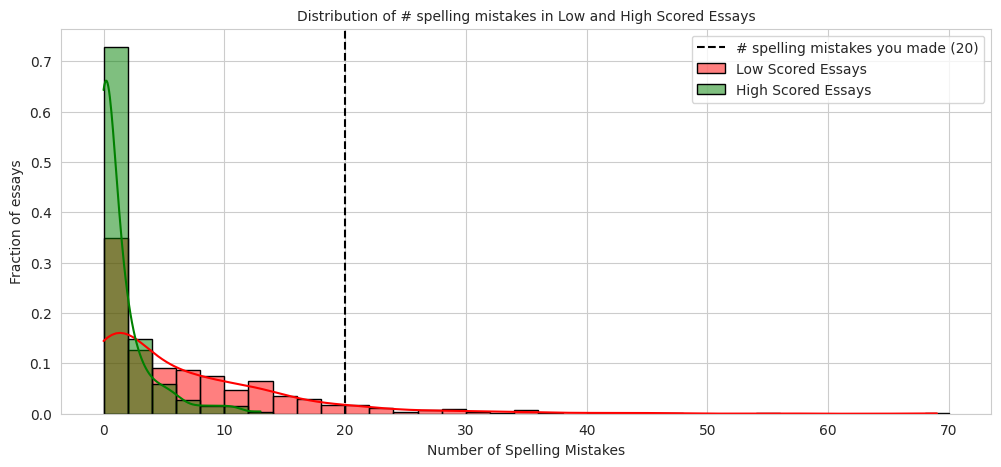

In [21]:
if run_first_time and essay:
    display(
        HTML(f"""<br><br><center><b style='background-color: yellow'>
        Essays with more than 10 spelling mistakes tend to score very low. You've made {df.num_mistakes[0]} spelling mistakes in your essay.
        </b></center><br>""")
    )
    plt.figure(figsize=(12, 5))

    # Plot the histograms of num_mistakes for low_df and high_df
    sns.histplot(data=processed_df[processed_df.score_category == "low"], x='num_mistakes', color='red', edgecolor='k',
                 binwidth=2, alpha=0.5, stat='probability', label='Low Scored Essays', kde=True)
    sns.histplot(data=processed_df[processed_df.score_category == "high"], x='num_mistakes', color='green', edgecolor='k',
                 binwidth=2, alpha=0.5, stat='probability', label='High Scored Essays', kde=True)

    plt.axvline(x=df.num_mistakes[0], label=f"# spelling mistakes you made ({df.num_mistakes[0]})", color='black', ls="--")

    # Set the chart title and axis labels
    plt.title('Distribution of # spelling mistakes in Low and High Scored Essays', fontsize=10)
    plt.xlabel('Number of Spelling Mistakes')
    plt.ylabel('Fraction of essays')

    plt.legend()
    plt.show()

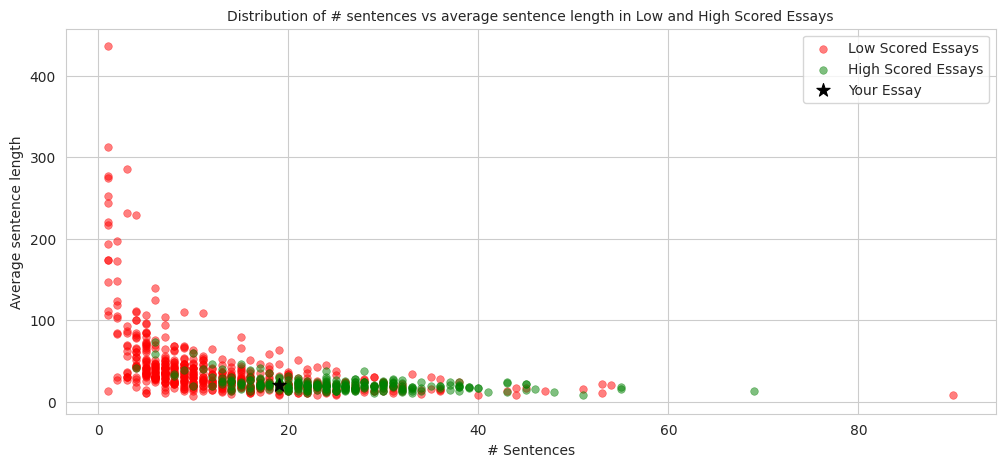

In [22]:
if run_first_time and essay:
    display(
        HTML(f"""<br><br><center><b style='background-color: yellow'>
        Essays with fewer and longer sentences tend to score very low.
        Your essay has {df.sent_count[0]} sentences and the average sentence length is {df.sent_len[0]}.
        </b></center><br>""")
    )
    plt.figure(figsize=(12, 5))
    
    sns.scatterplot(data=processed_df[processed_df.score_category == "low"], x='sent_count', y='sent_len',
                    alpha=0.5, color='red', label='Low Scored Essays', s=30, edgecolor='red')
    sns.scatterplot(data=processed_df[processed_df.score_category == "high"], x='sent_count', y='sent_len',
                    alpha=0.5, color='green', label='High Scored Essays', s=30, edgecolor='green')
    
    sns.scatterplot(x=[df.sent_count[0]], y=[df.sent_len[0]], color="black",
                    s=100, edgecolor='black', marker="*", label="Your Essay") 

    # Add plot titles and labels
    plt.title('Distribution of # sentences vs average sentence length in Low and High Scored Essays', fontsize=10)
    plt.xlabel('# Sentences')
    plt.ylabel('Average sentence length')

    plt.show()

In [32]:
if run_first_time and essay:
    display(
        HTML(f"""<br><h3 style='background-color: yellow; text-align: center'>
        Qualitative Analysis
        </h3>""")
    )
    analysis = chatgpt(essay)
    # print(analysis)
    
    for t in target_columns:
        for v in ["-", " -", ":", " :"]:
            analysis = analysis.replace(t + v, f"<b>{t + v}</b>")
            analysis = analysis.replace(t.capitalize() + v, f"<b>{t.capitalize() + v}</b>")
    
    analysis = analysis.replace("\n", "<br>")
    analysis = "<p style='background-color: #FFFFE0'>" + analysis + "</p>"
    display(HTML(analysis))